In [ ]:
import sys

import bertopic
import tqdm
!{sys.executable} -m pip install stanza --upgrade
!{sys.executable} -m pip install torch --upgrade


In [90]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(embeddings, labels):
    linked = linkage(embeddings, 'ward')
    plt.figure(figsize=(12, 6))
    dendrogram(linked, labels=labels, leaf_rotation=90)
    plt.show()


In [101]:
import pandas as pd
import ast
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

tqdm.pandas()  # Enables df.progress_apply

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def normalize_text(text):
    words = re.findall(r'[a-z0-9]+', text.lower())
    return " ".join(stemmer.stem(w) for w in words if w not in stop_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hodos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:

def extract_unique_amenities(df):
    unique = set()
    parsed_amenities = []
    
    for val in tqdm(df["amenities"], desc="Parsing amenities"):
        try:
            lst = ast.literal_eval(val) if isinstance(val, str) else []
            lst = [normalize_text(str(a)) for a in lst]
        except Exception:
            lst = []
        parsed_amenities.append(lst)
        unique.update(lst)
    print(len(unique))
    
    return list(unique), parsed_amenities

from collections import defaultdict

def cluster_amenities(unique_amenities, n_clusters=None):
    print(f"Encoding {len(unique_amenities)} unique amenities...")
    

    model = SentenceTransformer("all-MiniLM-L6-v2")

    embeddings = list(tqdm(model.encode(unique_amenities, show_progress_bar=True), 
                            total=len(unique_amenities), 
                            desc="Encoding embeddings"))
    
    if not n_clusters:
        n_clusters = max(2, int(len(unique_amenities) ** 0.5))
    
    print(f"Clustering into {n_clusters} groups...")
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(embeddings)
    
    # Group amenities by cluster
    cluster_to_amenities = defaultdict(list)
    for amenity, label in zip(unique_amenities, labels):
        cluster_to_amenities[label].append(amenity)
    
    # Pick a representative name for each cluster
    cluster_names = {}
    for cluster, items in cluster_to_amenities.items():
        # Pick the shortest name (after sorting)
        rep_name = sorted(items, key=len)[0]
        # Clean name for column use
        rep_name = rep_name.replace(" ", "_").replace("-", "_")
        cluster_names[cluster] = rep_name
    print(cluster_names)
    
    # Map amenity → cluster name
    amenity_to_cluster = {amenity: cluster_names[label] 
                          for amenity, label in zip(unique_amenities, labels)}
    plot_dendrogram(embeddings, unique_amenities)

    return amenity_to_cluster, cluster_to_amenities


def expand_amenities_semantic(df, amenity_to_cluster, parsed_amenities):
    cluster_names = set(amenity_to_cluster.values())
    
    # Initialize binary columns for each cluster name
    for cname in cluster_names:
        df[f"amenity_{cname}"] = 0
    
    for idx, lst in tqdm(enumerate(parsed_amenities), 
                         total=len(parsed_amenities), 
                         desc="Assigning amenities to clusters"):
        cluster_ids = {amenity_to_cluster[a] for a in lst if a in amenity_to_cluster}
        for cname in cluster_ids:
            df.at[idx, f"amenity_{cname}"] = 1
    
    return df

def process_airbnb_with_semantic_amenities(path, n_clusters=None):
    df = pd.read_csv(path)
    unique_amenities, parsed_amenities = extract_unique_amenities(df)
    print(type(unique_amenities))
    amenity_to_cluster, cluster_to_amenities = cluster_amenities(unique_amenities, n_clusters)
    df = expand_amenities_semantic(df, amenity_to_cluster, parsed_amenities)
    return df, cluster_to_amenities



Parsing amenities: 100%|██████████| 10168/10168 [00:12<00:00, 795.66it/s] 


2811
<class 'list'>
Encoding 2811 unique amenities...


Batches:   0%|          | 0/88 [00:00<?, ?it/s]

Encoding embeddings: 100%|██████████| 2811/2811 [00:00<00:00, 2774814.91it/s]


Clustering into 53 groups...
{30: 'tv_chromecast', 20: 'ga_stove', 3: 'tv_netflix', 39: 'elev', 22: '70_inch_hdtv_disney_netflix_premium_cabl', 0: 'oven', 29: 'coffe', 11: '65_inch_hdtv_disney', 9: 'backyard', 6: 'hdtv_fire_tv', 37: 'children_book_toy', 1: 'jbl_sound_system', 40: 'bose_sound_system_aux', 8: 'shampoo', 36: '55_inch_hdtv_hbo_max', 26: 'nux_bodi_soap', 7: 'gym', 21: 'fast_wifi_99_mbp', 17: 'tv', 33: 'dryer', 45: 'tv_dvd_player', 15: 'refriger', 48: 'wifi', 13: 'housekeep_avail_monday', 44: 'soni_sound_system', 35: 'tv_disney', 38: 'bbq_grill', 42: '39_inch_tv_chromecast', 28: 'cloth_storag', 2: 'tv_chromecast_premium_cabl', 25: 'bodi_soap', 34: 'sea_view', 51: 'miel_oven', 12: 'iron', 14: 'stove', 16: 'fast_wifi_53_mbp', 32: 'crib', 24: 'game_consol', 27: 'high_chair', 31: 'paid_park_premis', 23: '49_inch_hdtv_amazon_prime_video', 18: 'mari_stella_shampoo', 5: 'marcel_shampoo', 41: '85_inch_tv', 19: 'sound_system', 47: 'induct_stove', 49: 'exercis_equip_yoga_mat', 4: 'tv_

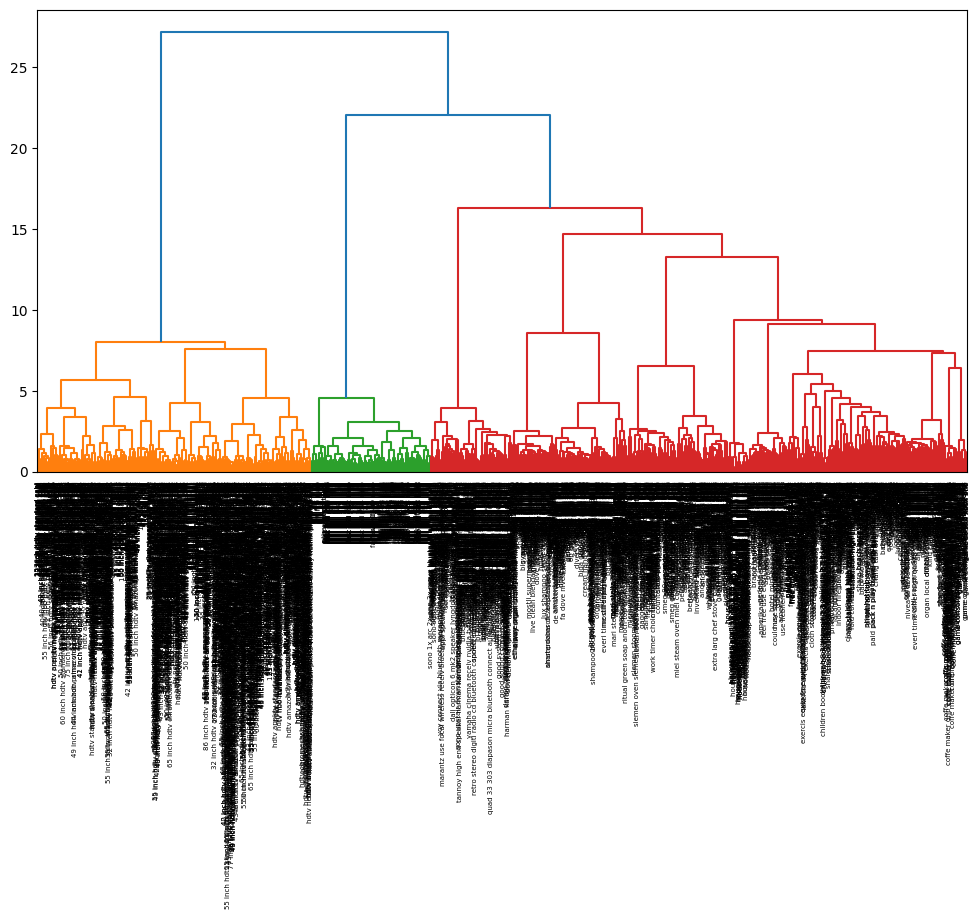

Assigning amenities to clusters: 100%|██████████| 10168/10168 [00:02<00:00, 3862.46it/s]


In [103]:
if __name__ == "__main__":
    df, mapping = process_airbnb_with_semantic_amenities(r"C:\Users\hodos\Documents\Uni\Uni-Year-3\Semester2\Data\cleaned_listings_amsterdam.csv")
    # df.to_csv("cleaned_with_clusters.csv", index=False)
    # print("Cluster mapping:", mapping)


In [87]:
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,amenity_aeg_oven,amenity_conditioner,amenity_clothing_storage,amenity_smeg_oven,amenity_kitchen,amenity_tv,amenity_indoor_fireplace,amenity_shower_gel,amenity_high_chair,amenity_shampoo
0,27886,https://www.airbnb.com/rooms/27886,20250609011745,2025-06-17,city scrape,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,...,0,0,1,0,1,0,0,1,0,1
1,28871,https://www.airbnb.com/rooms/28871,20250609011745,2025-06-17,city scrape,Comfortable double room,Basic bedroom in the center of Amsterdam.,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,...,0,0,0,0,0,0,0,1,0,1
2,29051,https://www.airbnb.com/rooms/29051,20250609011745,2025-06-17,city scrape,Comfortable single / double room,This room can also be rented as a single or a ...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,...,0,0,0,0,0,0,0,1,0,1
3,44391,https://www.airbnb.com/rooms/44391,20250609011745,2025-06-17,previous scrape,Quiet 2-bedroom Amsterdam city centre apartment,Guests greatly appreciate the unique location ...,The appartment is located in the city centre. ...,https://a0.muscache.com/pictures/97741545/3900...,194779,...,0,0,0,0,1,0,0,1,0,1
4,47061,https://www.airbnb.com/rooms/47061,20250609011745,2025-06-17,city scrape,Charming apartment in old centre,"A beautiful, quiet apartment in the center of ...",NaN,https://a0.muscache.com/pictures/268343/a08ce2...,211696,...,0,1,1,0,1,0,0,1,0,1
